In [1]:
#安装需要的各种类库
!pip install transformers==4.34.1 --upgrade #  支持 flash_attn_func
!pip install tensorrt
!pip install llmtuner==0.1.3   #训练依赖的类库
!pip install bitsandbytes>=0.39.0  # 量化操作需要的类库！
#FlashAttenttion-2 目前只支持 A100 或 H100  其他GPU不支持
!pip install packaging
!pip install ninja
!pip install flash-attn --no-build-isolation
!pip install openai
!pip install cohere
!pip install transformers_stream_generator
!pip install llm-rs --quiet
!pip install langchain --quiet
!pip install llm-rs[langchain] --quiet
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.4
    Uninstalling huggingface-hub-0.19.4:
      Successfully uninstalled huggingface-hub-0.19.4
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17281 sha256=8361f194192e61203b4d976e8c912fd0fd08b5efc5a353b9b373c5326f6e421e
  Stored in d

相关资料：

In [44]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import torch
from torch import nn
import numpy as np
import re
from transformers import LlamaTokenizer, LlamaForCausalLM
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, LlamaForSequenceClassification
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)
from tqdm import tqdm

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

In [58]:
# model_path = 'openlm-research/open_llama_3b' # https://huggingface.co/openlm-research/open_llama_3b
model_path ='togethercomputer/Llama-2-7B-32K-Instruct'
# num_labels = 4 # 'Positive', 'Neutral', 'Negative', 'Irrelevant' (https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2)
num_labels = 2 # True or False

model = LlamaForSequenceClassification.from_pretrained(model_path, num_labels=num_labels, torch_dtype=torch.float16, device_map='cuda:0') #device_map='cuda:0'
# Tokenize the input: Use the AutoTokenizer class from the transformers library to tokenize your input text. Set the tokenizer options according to your classification task.

tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    use_fast=False,
    trust_remote_code=True,
    padding_side="left",
    pad_token="<|endoftext|>"
)

model.resize_token_embeddings(len(tokenizer)) # https://github.com/huggingface/transformers/issues/1805

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at togethercomputer/Llama-2-7B-32K-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(32002, 4096)

In [59]:
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"], # https://github.com/huggingface/peft/blob/632997d1fb776c3cf05d8c2537ac9a98a7ce9435/src/peft/utils/other.py#L202
    lora_dropout=0.1,
    bias="none",   #bias="lora_only",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)

In [4]:
def basic_cleaning(text):
    # Capture swear words that are **** out return text
    text=re.sub(r'https?://www\.\S+\.com','',text)
    text=re.sub(r'[^A-Za-z|\s]','',text)
    text=re.sub(r'\*+','swear',text)
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" #emoticons
                               u"\U0001F300-\U0001F5FF" #symbols & pictographs
                               u"\U0001F680-\U0001F6FF" #transport & map symbols
                               u"\U0001F1E0-\U0001F1FF" #flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_multiplechars(text):
    text = re.sub(r'(.)\1{3,}',r'\1', text)
    return text

def clean(df):
    for col in ['text']:#,'selected_text']:
        df[col]=df[col].astype(str).apply(lambda x:basic_cleaning(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_emoji(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_html(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_multiplechars(x))
    return df

fetch the liar dataset



In [ ]:
#fetch the liar dataset from net
from datasets import load_dataset

liar_dataset = load_dataset("liar")


import pandas as pd
idx = 0
# show the data in the dataset
# have 3 dataset : train  ,  test  , validation
for key,v in liar_dataset.items():
  print(key)
  print(v)


# Access different dataset splits
train_dataset = liar_dataset["train"]
validation_dataset = liar_dataset["validation"]
test_dataset = liar_dataset["test"]

sample_example = train_dataset[0]
print(" : ",sample_example)
text = sample_example["statement"]
label = sample_example["label"]

print("Text:", text)
print("Label:", label)


# change the dataset
def datasetToCsv(dataset,name):
  labels =[]
  texts=[]
  for row in dataset:
    # print(row['label'])
    ll = row['label']
    if ll==0 or ll==5 or ll==4:
      labels.append('0')
    else:
      labels.append('1')
    texts.append(row['statement'])
  datas_dict={'text':texts,'label':labels}
  datas = pd.DataFrame(datas_dict)
  print(datas.info)
  datas.to_csv(name)

# change the dataset to the different type dataset
datasetToCsv(train_dataset,"liar_train.csv")

datasetToCsv(validation_dataset,"liar_validation.csv")
datasetToCsv(test_dataset,"liar_test.csv")


In [9]:
train_data = pd.read_csv("./liar_train.csv")
train_test = pd.read_csv('./liar_test.csv')

print("train_data.info ::   ",train_data.info)
print("train_test.info :: ",train_test.info)
#Obtain liar data for processing

if 'label' in train_data.columns:
  train_data['Type'] = train_data['label']
  train_data['Type'].astype('str')
if 'label' in train_test.columns:
  train_test['Type'] = train_test['label']
  train_test['Type'].astype('str')
# print(train_data.head())

train_data  = train_data[["text",'Type']]
# print(train_data.head())

train_test  = train_test[["text",'Type']]
# print(train_test.head())
# print("shape:: ",train_test.shape)

print("train_data:: ",train_data.info)

# train_data = pd.concat([train_data,train_test],axis=0)
# print("train_data:: ",train_data.info)

# setting
eval_data_twitter = train_test # train_data.sample(2000) #train_test  2000  300
data_twitter = train_data

earlyStopAtTrainBatchIdx = 2000 # Set these variables to None to train and validate on all the dataset
earlyStopAtValBatchIdx = 299 # Set these variables to None to train and validate on all the dataset


eval_data_twitter

train_data.info ::    <bound method DataFrame.info of        Unnamed: 0                                               text  label
0               0  Says the Annies List political group supports ...      0
1               1  When did the decline of coal start? It started...      1
2               2  Hillary Clinton agrees with John McCain "by vo...      1
3               3  Health care reform legislation is likely to ma...      0
4               4  The economic turnaround started at the end of ...      1
...           ...                                                ...    ...
10264       10264  There are a larger number of shark attacks in ...      1
10265       10265  Democrats have now become the party of the [At...      1
10266       10266  Says an alternative to Social Security that op...      1
10267       10267  On lifting the U.S. Cuban embargo and allowing...      0
10268       10268  The Department of Veterans Affairs has a manua...      0

[10269 rows x 3 columns]>
train_t

,text,Type
0,Building a wall on the U.S.-Mexico border will...,1
1,Wisconsin is on pace to double the number of l...,0
2,Says John McCain has done nothing to help the ...,0
3,Suzanne Bonamici supports a plan that will cut...,1
4,When asked by a reporter whether hes at the ce...,0
...,...,...
1278,Says his budget provides the highest state fun...,1
1279,Ive been here almost every day.,0
1280,"In the early 1980s, Sen. Edward Kennedy secret...",0
1281,Says an EPA permit languished under Strickland...,0


In [61]:
#使用真假新闻的数据
data_twitter_clean = clean(data_twitter)
eval_data_twitter_clean = clean(eval_data_twitter)
eval_data_twitter_clean
data_twitter_clean

,Unnamed: 0,text,Type
295,10150,CRAZED PROTESTERS Pull Down Confederate Statue...,0
1369,14195,BIKERS FOR TRUMP Will Travel To Future Rallies...,0
1960,123,Republican tax bill retains US electric vehic...,1
1320,7310,One person shot in Portland as antiTrump prote...,1
173,16312,The White House is increasing the number of r...,0
...,...,...,...
1697,23094,UN investigators found evidence that alleged ...,0
192,3068,Former US Attorney Preet Bharara signs book d...,1
1074,3677,Approval of President Trump drops to lowest s...,1
820,9885,CNN Cuts Off Black Trump Supporter When He An...,0


In [11]:
class CustomDataset(Dataset):
    def __init__(self, twitterDF):
        self.twitterDF = twitterDF

    def __len__(self):
        return len(self.twitterDF.index)

    def __getitem__(self, idx):
        return np.array([idx])

In [62]:
train_twitter_dataset = CustomDataset(data_twitter_clean)
train_twitter_dataloader = DataLoader(train_twitter_dataset,batch_size=2,shuffle=True,drop_last=True)


eval_twitter_dataset = CustomDataset(eval_data_twitter_clean)
eval_twitter_dataloader = DataLoader(eval_twitter_dataset,batch_size=2,shuffle=True,drop_last=True)

def showimage(y_values,text):
  import matplotlib.pyplot as plt
  plt.figure()
  # 去除顶部和右边框框
  ax=plt.axes()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.xlabel('Round')    # x轴标签

  if text=='Score' or text=='Accuracy':
    plt.ylabel('Accuracy')     # y轴标签
  else:
    plt.ylabel('Loss')     # y轴标签

	# 默认颜色，如果想更改颜色，可以增加参数color='red',这是红色。
  size = len(y_values)
  x_values=[]
  for x in range(size):
    x_values.append(x+1)

  plt.plot(x_values, y_values, linewidth=1, linestyle="solid", label="The Test "+text)
  plt.legend()
  plt.title(text)
  plt.savefig(text+'.png')
  plt.show()

score_nums = []
loss_nums = []


epochs:  0


100%|██████████| 600/600 [01:33<00:00,  6.38it/s]




Epoch 1/12, Loss: 0.3528649775187174
fake news validation accuracy:  0.8433333039283752
epochs:  1


100%|██████████| 600/600 [01:33<00:00,  6.41it/s]




Epoch 2/12, Loss: 0.17364641507466635
fake news validation accuracy:  0.9366666674613953
epochs:  2


100%|██████████| 600/600 [01:33<00:00,  6.39it/s]




Epoch 3/12, Loss: 0.16607178886731466
fake news validation accuracy:  0.9566666483879089
epochs:  3


100%|██████████| 600/600 [01:33<00:00,  6.40it/s]




Epoch 4/12, Loss: 0.17166052937507628
fake news validation accuracy:  0.9566666483879089


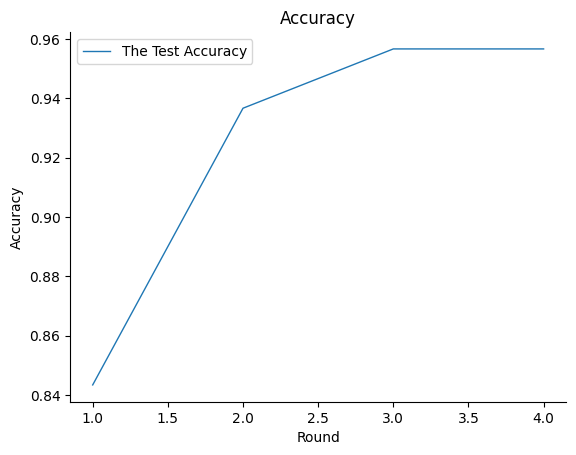

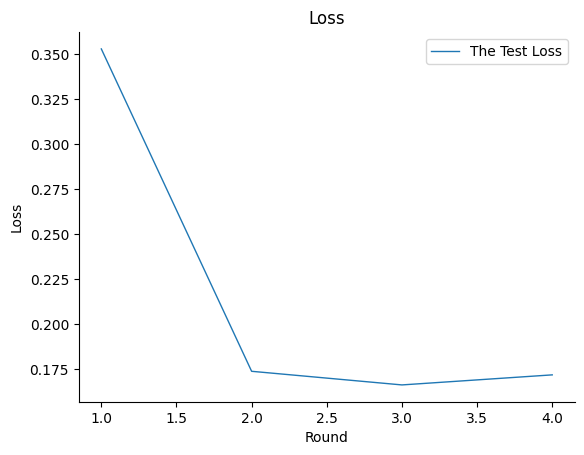

epochs:  4


100%|██████████| 600/600 [01:34<00:00,  6.37it/s]




Epoch 5/12, Loss: 0.1771286388238271
fake news validation accuracy:  0.95333331823349
epochs:  5


100%|██████████| 600/600 [01:33<00:00,  6.41it/s]




Epoch 6/12, Loss: 0.16142624219258625
fake news validation accuracy:  0.9666666388511658
epochs:  6


100%|██████████| 600/600 [01:33<00:00,  6.40it/s]




Epoch 7/12, Loss: 0.16168830037117005
fake news validation accuracy:  0.9633333086967468


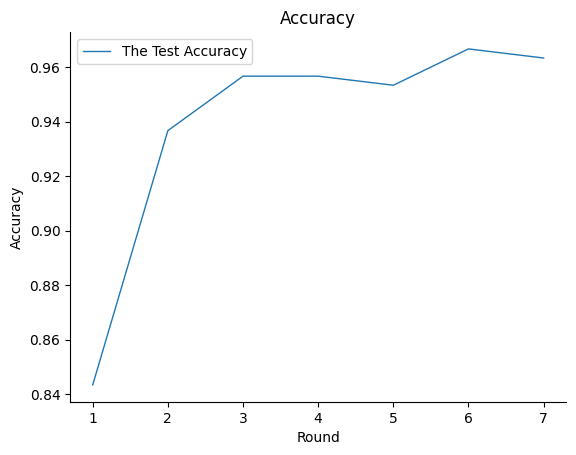

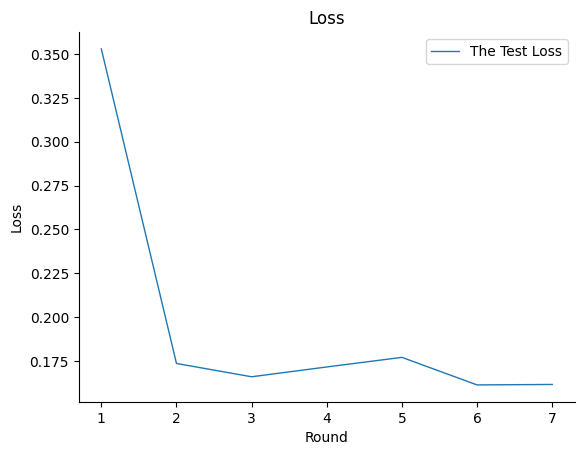

epochs:  7


100%|██████████| 600/600 [01:33<00:00,  6.39it/s]




Epoch 8/12, Loss: 0.16939948399861654
fake news validation accuracy:  0.9633333086967468
epochs:  8


100%|██████████| 600/600 [01:33<00:00,  6.40it/s]




Epoch 9/12, Loss: 0.17783127188682557
fake news validation accuracy:  0.9633333086967468
epochs:  9


100%|██████████| 600/600 [01:33<00:00,  6.40it/s]




Epoch 10/12, Loss: 0.1896074895064036
fake news validation accuracy:  0.9633333086967468


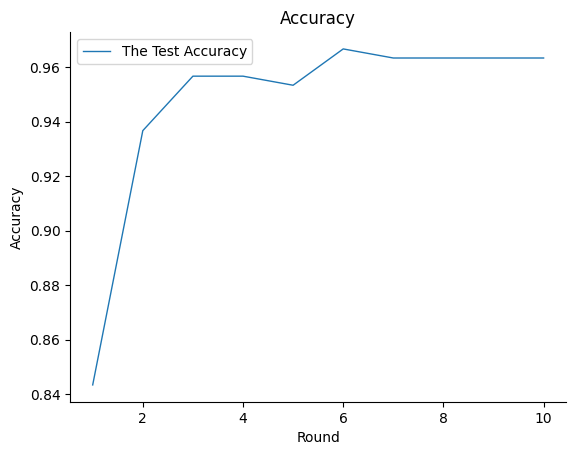

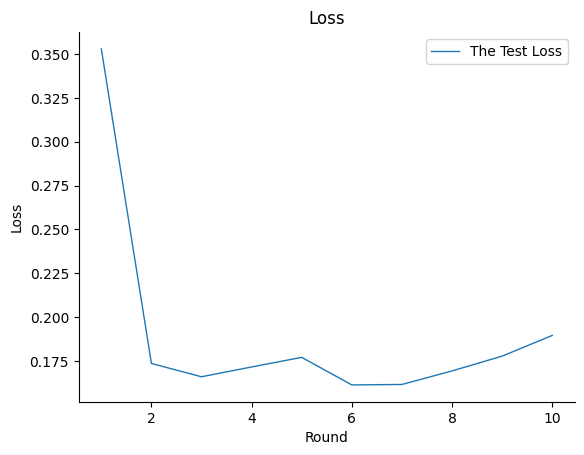

epochs:  10


100%|██████████| 600/600 [01:34<00:00,  6.37it/s]




Epoch 11/12, Loss: 0.19119178175926207
fake news validation accuracy:  0.9633333086967468
epochs:  11


100%|██████████| 600/600 [01:33<00:00,  6.42it/s]




Epoch 12/12, Loss: 0.20107049226760865
fake news validation accuracy:  0.9633333086967468


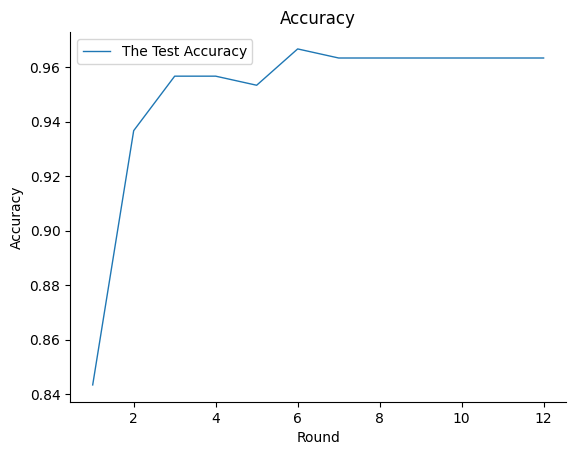

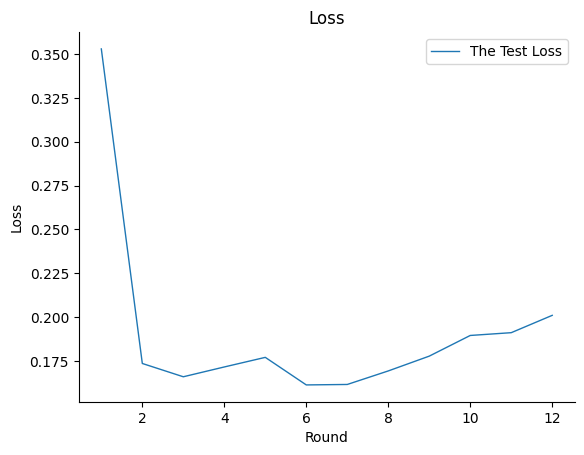

In [63]:
# Define your training loop
epochs = 12
# Let's just train on a small batch of the dataset and see the validation score
#fakenews dataset

# earlyStopAtTrainBatchIdx = 450 # Set these variables to None to train and validate on all the dataset
# earlyStopAtValBatchIdx = 30 # Set these variables to None to train and validate on all the dataset


#liar dataset configer
earlyStopAtTrainBatchIdx = 3400 # Set these variables to None to train and validate on all the dataset
earlyStopAtValBatchIdx = 299 # Set these variables to None to train and validate on all the dataset

# twitter dataset configer
# earlyStopAtTrainBatchIdx = 850 # Set these variables to None to train and validate on all the dataset
# earlyStopAtValBatchIdx = 100 # Set these variables to None to train and validate on all the dataset


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()
device="cuda"

for epoch in range(epochs):
    print("epochs: ", epoch)
    total_loss = 0
    error_epoch = 0
    for batchIdx, sampledIdx in enumerate(tqdm(train_twitter_dataloader, position=0, leave=True)):
        # print("sampledIdx:: ",sampledIdx)
        sampledIdx = sampledIdx.cpu().data.numpy()
        model.train()
        optimizer.zero_grad()
        select_idxs= list(sampledIdx.flatten())
        # print("list(sampledIdx.flatten()) :: ",select_idxs)
        sampledRowText = list(data_twitter_clean["text"].iloc[select_idxs])
        # print("sampledRowText> \n ",sampledRowText)
        # print("len >  \n ",len(sampledRowText[2]))

        data_twitter_clean_types = data_twitter_clean["Type"].iloc[select_idxs]

        list_data_twitter_clean_types = list(data_twitter_clean_types)

        sampledRowLabels = torch.tensor(list_data_twitter_clean_types).to(device)
        # sampledRowLabels = torch.tensor(list(ipp)).to(device)
        encoded_input = tokenizer(sampledRowText, truncation=True, padding=True, return_tensors='pt').to(device) # Output shape: [bs, num_Labels]
        encoded_inputIds = encoded_input["input_ids"].to(device)
        encoded_attnMask = encoded_input["attention_mask"].to(device)
        # print("encoded_inputIds size >> ",len(encoded_inputIds[3]))
        outputs = model(input_ids=encoded_inputIds, attention_mask=encoded_attnMask)
        logits = outputs.logits
        # loss_num = outputs.loss
        # print("loss_num :: ",loss_num)
        # total_loss +=loss_num.item()

        pred_labels = logits.squeeze()
        # print("\n pred_labels :: ",pred_labels)
        # print("\n sampledRowLabels :: ",sampledRowLabels)
        if len(pred_labels)==len(sampledRowLabels):
          loss = loss_fn(logits.squeeze(), sampledRowLabels)
          # lossItem = loss.item()
          # total_loss +=lossItem
          # print("\n lossItem :: ",lossItem)
          loss.backward()
          optimizer.step()
        else:
          pass
          # error_epoch = error_epoch+1
        # break

        # if earlyStopAtTrainBatchIdx!=None:
        #     if batchIdx==earlyStopAtTrainBatchIdx: break

    # print("\n  len(train_twitter_dataloader) :: ",len(train_twitter_dataloader))

    # Validation
    predLs = []
    labelLs = []
    test_total = 0
    # for batchIdx, sampledIdx in enumerate(eval_twitter_dataset):
    for batchIdx, sampledIdx in enumerate(eval_twitter_dataloader):
        model.eval()
        # print("batchIdx :: ",batchIdx)
        # print("sampledIdx :: ",sampledIdx)
        # print("sampledIdx.flatten() :: ",sampledIdx.flatten())
        # print("len(eval_data_twitter_clean) :: ",len(eval_data_twitter_clean))
        if batchIdx >= len(eval_twitter_dataloader):
          error_epoch = error_epoch+1
          break#预防下标越界而报错
        sampledRowText = list(eval_data_twitter_clean["text"].iloc[list(sampledIdx.flatten())])
        sampledRowLabels = torch.tensor(list(eval_data_twitter_clean["Type"].iloc[list(sampledIdx.flatten())])).to(device)
        encoded_input = tokenizer(sampledRowText, truncation=True, padding=True, return_tensors='pt').to(device) # Output shape: [bs, num_Labels]
        encoded_inputIds = encoded_input["input_ids"].to(device)
        encoded_attnMask = encoded_input["attention_mask"].to(device)
        # print("encoded_inputIds size >> ",len(encoded_inputIds))
        outputs = model(input_ids=encoded_inputIds, attention_mask=encoded_attnMask)
        logits = outputs.logits
        # print(" logits.squeeze()::  ",logits.squeeze())
        # print(" sampledRowLabels::  ",sampledRowLabels)
        loss = loss_fn(logits.squeeze(), sampledRowLabels)
        lossItem = loss.item()
        total_loss +=lossItem
        test_total = test_total+1
        predLs.append(torch.argmax(logits, dim=1).flatten().cpu().data.numpy())
        labelLs.append(sampledRowLabels.cpu().data.numpy())

        # if earlyStopAtValBatchIdx!=None:
        #     if batchIdx==earlyStopAtValBatchIdx: break

    avg_loss = total_loss /test_total
    loss_nums.append(avg_loss)
    print("\n")
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')
    # print('predLs :: ',predLs)
    predLs = torch.tensor(predLs).flatten()
    labelLs = torch.tensor(labelLs).flatten()
    accuracy = Accuracy(task="multiclass", num_classes=2)
    valAcc = float(accuracy(predLs, labelLs))
    score_nums.append(valAcc)
    print("fake news validation accuracy: ", valAcc)
    if  epoch%3==0 or epoch + 1==epochs:
      if epoch!=0:
          showimage(score_nums,"Accuracy")
          showimage(loss_nums,"Loss")

In [64]:
print(score_nums)
print(loss_nums)
print(data_twitter_clean.shape)
print(eval_data_twitter_clean.shape)
# data_twitter_clean = clean(data_twitter)
# eval_data_twitter_clean = clean(eval_data_twitter)
# print(labels)
data_static = pd.DataFrame({'loss':loss_nums,'score':score_nums})

print(data_static)

print("max is :: ",data_static['score'].max())
print("min is :: ",data_static['score'].min())
print("std is :: ",data_static['score'].std())
print("mean is :: ",data_static['score'].mean())

[0.8433333039283752, 0.9366666674613953, 0.9566666483879089, 0.9566666483879089, 0.95333331823349, 0.9666666388511658, 0.9633333086967468, 0.9633333086967468, 0.9633333086967468, 0.9633333086967468, 0.9633333086967468, 0.9633333086967468]
[0.3528649775187174, 0.17364641507466635, 0.16607178886731466, 0.17166052937507628, 0.1771286388238271, 0.16142624219258625, 0.16168830037117005, 0.16939948399861654, 0.17783127188682557, 0.1896074895064036, 0.19119178175926207, 0.20107049226760865]
(1200, 3)
(300, 3)
        loss     score
0   0.352865  0.843333
1   0.173646  0.936667
2   0.166072  0.956667
3   0.171661  0.956667
4   0.177129  0.953333
5   0.161426  0.966667
6   0.161688  0.963333
7   0.169399  0.963333
8   0.177831  0.963333
9   0.189607  0.963333
10  0.191192  0.963333
11  0.201070  0.963333
max is ::  0.9666666388511658
min is ::  0.8433333039283752
std is ::  0.03437268578218544
mean is ::  0.949444423119227


<bound method DataFrame.info of        Unnamed: 0                                               text  label
0               0  Says the Annies List political group supports ...      0
1               1  When did the decline of coal start? It started...      1
2               2  Hillary Clinton agrees with John McCain "by vo...      1
3               3  Health care reform legislation is likely to ma...      0
4               4  The economic turnaround started at the end of ...      1
...           ...                                                ...    ...
10264       10264  There are a larger number of shark attacks in ...      1
10265       10265  Democrats have now become the party of the [At...      1
10266       10266  Says an alternative to Social Security that op...      1
10267       10267  On lifting the U.S. Cuban embargo and allowing...      0
10268       10268  The Department of Veterans Affairs has a manua...      0

[10269 rows x 3 columns]>
<bound method DataFrame.info 

,text,Type
2053,"""When I was in college, we used to take a popc...",1
5922,President Obamas proposal calls for serious cu...,1
7967,Dave Brat worked on Democrat Gov. Tim Kaines C...,1
6652,The Seattle Times called Patty Murray a prolif...,1
7549,Federal government reneging on Medicaid paymen...,0
...,...,...
4262,"Every taxpayer owes about $130,000 to pay off ...",1
8445,His biography says he was the top ROTC officer...,1
5608,Wisconsin is called the Badger State because o...,1
9690,Obamacare cuts $500 billion in future Medicare...,1


In [36]:

# data_twitter_clean = clean(data_twitter)
# eval_data_twitter_clean = clean(eval_data_twitter)
# eval_data_twitter_clean

import pandas as pd
import numpy as np

train_data = pd.read_csv("./tweet_Constraint_Train.csv")#
train_data = train_data.sample(3000)
# test_data = pd.read_csv("./Constraint_Test.csv")
print("train_data :: \n ",train_data)
# print("test_data :: \n ",test_data)

# train_data['text']=train_data['tweet']
# train_data['Type']=train_data['label']

def change_csv(data,typestr):
  pp = data[data['label']==typestr]
  # print("train_data :: \n ",pp)
  if typestr=='real':
    pp['label']=1
  else:
    pp['label']=0
  # print("train_data :: \n ",pp)
  pp.rename(columns={'label':'Type','tweet':"text"},inplace=True)
  pp = pp[{'text','Type'}]
  # print("train_data :: \n ",pp.columns)
  # print("train_data :: \n ",pp)
  return pp

real = change_csv(train_data,'real')
fake = change_csv(train_data,'fake')
data_twitter = pd.concat([real,fake],axis=0)
print("dd is :::\n  ",data_twitter)
sum_idx = data_twitter.shape[0]
print('sum_idx :: ',sum_idx)
data_twitter = data_twitter.take(np.random.permutation(sum_idx))
print("twitter_data :: \n ",data_twitter)

earlyStopAtTrainBatchIdx = 850 # Set these variables to None to train and validate on all the dataset
earlyStopAtValBatchIdx = 100

eval_data_twitter = data_twitter.sample(300)
print("eval_twitter_data :: \n ",eval_data_twitter.index)
eval_index = eval_data_twitter.index
for e_idx in eval_index:
  # print(e_idx)
  data_twitter = data_twitter.drop(index=e_idx)

# data_train = data_index-eval_index
# print("twitter_data ::: \n",data_twitter)
# print(data_twitter.loc[0])


train_data :: 
          id                                              tweet label
4582  4583  We have reached out to Julius Berger clinic in...  real
445    446  California has announced a frustrating decisio...  real
980    981  RT @PIB_India: ▪️ Highest ever 56383 recoverie...  real
1358  1359  Recording yet another day with 50000+ new infe...  fake
462    463  Condom Sales Are At An All-Time High https://t...  fake
...    ...                                                ...   ...
923    924  If you’ve seen the news that the Federal gover...  real
782    783  COVID-19 is an abbreviation for coronavirus di...  fake
2080  2081  Forty-nine new cases of #COVID19 have been rep...  real
864    865  Widely available steroid reduced COVID-19 deat...  fake
2887  2888  Yesterday our laboratories processed 6006 test...  real

[3000 rows x 3 columns]
dd is :::
         Type                                               text
4582     1  We have reached out to Julius Berger clinic in...
445  

In [57]:
#释放GPU内存
import torch
import gc

# model.cpu()
# del model, tokenizer
gc.collect()
torch.cuda.empty_cache()


# model = None
# tokenizer = None

def free():
  import torch
  import gc
  # model.cpu()
  del model, tokenizer
  gc.collect()
  torch.cuda.empty_cache()

free()

UnboundLocalError: ignored

In [ ]:
model.save_pretrained("train_model")

In [ ]:
lora_model.save_pretrained("./train_lora")

In [ ]:
import pandas as pd
# fake news long text more 500 words
data = pd.read_csv('./long_True.csv')
fake = pd.read_csv('./long_Fake.csv')
# print(data)

data = data.sample(1000)
fake = fake.sample(1000)
data['text']=data['title']+". "+ data['text']
fake['text']=fake['title']+". "+ fake['text']
data["Type"] = 1
fake["Type"] = 0
data = pd.concat([data,fake],axis=0)
data = data.sample(2000,random_state=999)
# data=data['text']
# print(data)
def getsize(v):
  texts = v.split()
  return len(texts)

def getlen(v):
  return len(v)

print(data)


                                                   title  \
21042  MIGRANT GIRLS AS YOUNG AS 11 Arrive In Sweden ...   
7107    The Panama Papers: How The 1%’s Greed Has Lit...   
112    White House optimistic Congress will avoid gov...   
5765   Medical group urges protection for doctors, pa...   
3248    Trump Gets HUMILIATED After His Latest Stupid...   
...                                                  ...   
12991  SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...   
3644   Trump asked two top intelligence officials to ...   
18916  Eating leaves to survive in Myanmar's 'ethnic ...   
6150   Trump son-in-law Kushner can serve as White Ho...   
15913  OBAMA HID BIN LADEN PAPERS To Bury This Damnin...   

                                                    text          subject  \
21042  MIGRANT GIRLS AS YOUNG AS 11 Arrive In Sweden ...        left-news   
7107    The Panama Papers: How The 1%’s Greed Has Lit...             News   
112    White House optimistic Congress will avoi

In [ ]:
from transformers import pipeline


def summarize_text(text,summarizer, max_length=200):
    texts = text.split()
    # print("text:: ",text)
    # print("len:: ",len(texts))
    if len(texts)<=max_length:
      return text
    if summarizer==None:
      summarizer = pipeline("summarization")
    minstr =" "
    try :
      summary = summarizer(text, max_length=max_length, min_length=60, length_penalty=2.0, max_time=120)
      minstr = summary[0]['summary_text']
    except:
      # print("len:: in except ..")
      minstr = " ".join(texts[0:max_length-1])
    else:
      pass
    return minstr



# summarizer the text
summarizer = pipeline("summarization")


def summerize_text_data(data,summarizer):
  data["text"] = data["text"].apply(lambda x:summarize_text(x,summarizer,max_length=200))
  data=data[["text",'Type']]
  return data

data = summerize_text_data(data,summarizer)


print(data)



No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Token indices sequence length is longer than the specified maximum sequence length for this model (1244 > 1024). Running this sequence through the model will result in indexing errors


                                                    text  Type
21042   Of the 61 married minors who sought asylum in...     0
7107    The Panama Papers: How The 1%’s Greed Has Lit...     0
112    White House optimistic Congress will avoid gov...     1
5765    American Medical Association urges protection...     1
3248   Trump Gets HUMILIATED After His Latest Stupid-...     0
...                                                  ...   ...
12991   Hillary Clinton ally David Brock is offering ...     0
3644   Trump asked two top intelligence officials to ...     1
18916  Eating leaves to survive in Myanmar's 'ethnic ...     1
6150    U.S. Department of Justice: President can hir...     1
15913   The Obama administration hand-picked just a f...     0

[2000 rows x 2 columns]


In [ ]:
data.to_csv("./long_fake_news_after_summerize.csv")
data

In [60]:
import pandas as pd
import random
# print(data.shape)
# print(data.shape[0])
# print(type(data.shape[0]))
data = pd.read_csv("./long_fake_news_after_summerize.csv")
data = data.sample(1500)
# print(data.index)
def split_train_test(data):
  import pandas as pd
  import random
  test_number = data.shape[0]*0.2
  test = []
  for _ in range(int(test_number)):
    random_index = random.choice(data.index)
    random_sample = data.loc[random_index]
    test.append(random_sample)
    data = data.drop(index=random_index)
  test_pd = pd.DataFrame(test)
  return data,test_pd

data_twitter,eval_data_twitter = split_train_test(data)

print(data_twitter)
print(eval_data_twitter)

      Unnamed: 0                                               text  Type
295        10150  CRAZED PROTESTERS Pull Down Confederate Statue...     0
1369       14195  BIKERS FOR TRUMP Will Travel To Future Rallies...     0
1960         123   Republican tax bill retains U.S. electric veh...     1
1320        7310  One person shot in Portland as anti-Trump prot...     1
173        16312   The White House is increasing the number of r...     0
...          ...                                                ...   ...
1697       23094   U.N. investigators found evidence that allege...     0
192         3068   Former U.S. Attorney Preet Bharara signs book...     1
1074        3677   Approval of President Trump drops to lowest s...     1
820         9885   CNN Cuts Off Black Trump Supporter When He An...     0
1093       15963   Indonesian national suspected to be among pro...     1

[1200 rows x 3 columns]
      Unnamed: 0                                               text  Type
242         4

In [ ]:
print(data_twitter['Type'])
print(eval_data_twitter['Type'])

17534    1
1529     1
9405     0
11699    1
20973    1
        ..
7502     1
17448    0
6658     0
5805     0
18659    0
Name: Type, Length: 360, dtype: object
18965    0
16267    1
831      1
18079    1
8012     1
17513    0
11968    1
1975     0
22515    0
5791     1
19826    1
16183    1
16028    0
12999    1
186      1
22354    0
20942    1
17990    0
4215     0
21798    0
2242     1
3266     1
1611     0
18646    1
4984     1
11528    0
14629    0
19145    0
4910     1
14143    1
12822    0
3883     1
13565    1
258      0
18630    0
13033    1
14997    1
8171     0
15301    1
19344    0
Name: Type, dtype: object
